In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
path_80k = 'seek80k_jobs.csv'
path_100k = 'seek100k_jobs.csv'

In [4]:
df_80k = pd.read_csv(path_80k).drop(columns = ['Unnamed: 0'])
df_100k = pd.read_csv(path_100k).drop(columns = ['Unnamed: 0'])

In [5]:
df_80k.head(2)

,url,job_title,company,date,location,employment_type,field,description
0,https://www.seek.com.au/job/37428435?type=prom...,Tender / Bid Leader - Data Collection & Road A...,Australian Road Research Board,10 Oct 2018,Brisbane,Full Time,Engineering,"About us:Established in 1960, the Australian R..."
1,https://www.seek.com.au/job/37512965?type=prom...,Commercial Analyst,NaN,19 Oct 2018,Cairns & Far North,Full Time,Accounting,Coral Expeditions is Australia's Pioneering Ex...


In [6]:
df_100k.head(2)

,url,job_title,company,date,location,employment_type,field,description
0,https://www.seek.com.au/job/37393509?type=prom...,Enterprise Data & Reporting Lead,NaN,5 Oct 2018,Melbourne,Full Time,Information & Communication Technology,About SEEK SEEK is the global leader in the cr...
1,https://www.seek.com.au/job/37394390?type=prom...,C# Software Engineer |GUI | Market Data |Equit...,Kapital Consulting,5 Oct 2018,Sydney,Full Time,Information & Communication Technology,About the Role An opportunity is available for...


### Remove Duplicate

In [7]:
df_80k = df_80k[~df_80k.description.duplicated()]

In [8]:
df_100k = df_100k[~df_100k.description.duplicated()]

### add pay target 1 to 100k and 0 to 80k

In [9]:
df_100k['pay'] = 1
df_80k['pay'] = 0

In [10]:
df_80k.head(3)

,url,job_title,company,date,location,employment_type,field,description,pay
0,https://www.seek.com.au/job/37428435?type=prom...,Tender / Bid Leader - Data Collection & Road A...,Australian Road Research Board,10 Oct 2018,Brisbane,Full Time,Engineering,"About us:Established in 1960, the Australian R...",0
1,https://www.seek.com.au/job/37512965?type=prom...,Commercial Analyst,NaN,19 Oct 2018,Cairns & Far North,Full Time,Accounting,Coral Expeditions is Australia's Pioneering Ex...,0
2,https://www.seek.com.au/job/37523713?type=stan...,Data Analyst,Youfoodz Pty Ltd,22 Oct 2018,Brisbane,Full Time,Marketing & Communications,You've heard about us…You've watched as we hav...,0


In [11]:
df = pd.concat([df_100k, df_80k], axis = 0)

### Reshuffle row

In [12]:
df = df.sample(frac=1).reset_index(drop = True)

In [13]:
df.employment_type.unique()

array(['Contract/Temp', 'Full Time', 'Part Time', 'Casual/Vacation'],
      dtype=object)

### Clean data

In [14]:
df.shape

(6701, 9)

In [15]:
df.isnull().sum()

url                   0
job_title             0
company            2173
date                  0
location              0
employment_type       0
field                 0
description           2
pay                   0
dtype: int64

#### Remove null values

In [16]:
df = df[~df['field'].isnull()]

In [17]:
df = df[~df['description'].isnull()]

In [18]:
df = df.drop(columns = ['company'])

In [19]:
df.isnull().sum()

url                0
job_title          0
date               0
location           0
employment_type    0
field              0
description        0
pay                0
dtype: int64

In [20]:
# check baseline
baseline = 1 - df['pay'].mean()

In [21]:
baseline

0.51649499925362

#### Extracting year and month

In [22]:
# convert to datetime
df['date_time'] = pd.to_datetime(df['date'])

In [23]:
def getYear(value):
    return value.year

def getMonth(value):
    return value.month

In [24]:
df['year'] = df['date_time'].apply(getYear)
df['month'] = df['date_time'].apply(getMonth)

In [25]:
df.drop(columns = ['date', 'date_time'], inplace = True)

#### Combine the job title into the job description

In [26]:
# combine the job title with description into 1 field
df['full_description'] = df['job_title'].values + ' ' +  df['description'].values
    

In [27]:
df.head()

,url,job_title,location,employment_type,field,description,pay,year,month,full_description
0,https://www.seek.com.au/job/37511263?type=stan...,Part Time Customer Service Officer,Adelaide,Contract/Temp,Call Centre & Customer Service,We are currently seeking an experienced custom...,0,2018,10,Part Time Customer Service Officer We are curr...
1,https://www.seek.com.au/job/37519438?type=stan...,ILS Lead Engineer & ILS Engineer (x4),Adelaide,Full Time,Engineering,ILS Lead Engineer – Min 5 years ILS & people m...,1,2018,10,ILS Lead Engineer & ILS Engineer (x4) ILS Lead...
2,https://www.seek.com.au/job/37492206?type=stan...,Senior Finance Officer,Sydney,Full Time,Accounting,We are currently seeking a skilled Senior Fina...,0,2018,10,Senior Finance Officer We are currently seekin...
3,https://www.seek.com.au/job/37452873?type=stan...,Penetration Tester,Sydney,Full Time,Information & Communication Technology,Role Highlights Join an Australian company whi...,1,2018,10,Penetration Tester Role Highlights Join an Aus...
4,https://www.seek.com.au/job/37486647?type=stan...,Senior HVAC Drafter,Sydney,Full Time,Engineering,This position offers a market leading salary f...,1,2018,10,Senior HVAC Drafter This position offers a mar...


In [28]:
df = df.drop(columns = ['job_title', 'description'])

In [29]:
df.head()

,url,location,employment_type,field,pay,year,month,full_description
0,https://www.seek.com.au/job/37511263?type=stan...,Adelaide,Contract/Temp,Call Centre & Customer Service,0,2018,10,Part Time Customer Service Officer We are curr...
1,https://www.seek.com.au/job/37519438?type=stan...,Adelaide,Full Time,Engineering,1,2018,10,ILS Lead Engineer & ILS Engineer (x4) ILS Lead...
2,https://www.seek.com.au/job/37492206?type=stan...,Sydney,Full Time,Accounting,0,2018,10,Senior Finance Officer We are currently seekin...
3,https://www.seek.com.au/job/37452873?type=stan...,Sydney,Full Time,Information & Communication Technology,1,2018,10,Penetration Tester Role Highlights Join an Aus...
4,https://www.seek.com.au/job/37486647?type=stan...,Sydney,Full Time,Engineering,1,2018,10,Senior HVAC Drafter This position offers a mar...


#### Look at location and convert to states only

In [30]:
location_list = df.location.unique().tolist()

In [31]:
from geopy.geocoders import Nominatim

In [32]:
def getAddress(value):
    try:
        geolocator = Nominatim(user_agent="specify_your_app_name_here")
        location = geolocator.geocode(str(value))

        address = location.address
    except:
        address = None
    
    return address

In [33]:
len(location_list)

62

In [34]:
# use the geopy library to find the address of the location.
geopy_translate_dict = {}
address_list = []
for location in log_progress(location_list):
    if 'Perth' in location or 'perth' in location:
        address_list.append('WA')
    elif 'Lockyer' in location:
        address_list.append('QLD')
    elif 'Mackay' in location:
        address_list.append('QLD')
    elif 'Port Hedland' in location:
        address_list.append('WA')
    elif 'Cairns' in location:
        address_list.append('QLD')
    elif 'Yarra Valley' in location:
        address_list.append('VIC')
    elif 'Whyalla' in location:
        address_list.append('SA')
    elif 'Bundaberg' in location:
        address_list.append('QLD')
    elif 'Bendigo' in location:
        address_list.append('VIC')
    elif 'Albany' in location:
        address_list.append('WA')
    elif 'Fleurieu Peninsula' in location:
        address_list.append('SA')
    elif 'Geraldton' in location:
        address_list.append('WA')
    elif 'Kalgoorlie' in location:
        address_list.append('WA')
    elif 'Adelaide' in location:
        address_list.append('SA')
    elif 'Port Macquarie' in location:
        address_list.append('NSW')
    elif 'Lismore' in location:
        address_list.append('NSW')
    elif 'Mornington Peninsula' in location:
        address_list.append('VIC')
    elif 'Coober Pedy' in location:
        address_list.append('SA')
    elif 'Yorke Peninsula' in location:
        address_list.append('SA')
    elif 'Northam' in location:
        address_list.append('WA')
    elif 'Tamworth & North West NSW' in location:
        address_list.append('NSW')
    elif 'Southern Highlands & Tablelands' in location:
        address_list.append('NSW')
    elif 'Riverland & Murray Mallee' in location:
        address_list.append('SA')
    
    else:
        try:
            new_address = getAddress(location)
            address_list.append(new_address)
            geopy_translate_dict[location] = new_address
        except:
            address_list.append(location)
        

In [35]:
geopy_translate_dict

{'Sydney': 'Sydney, NSW, Australia',
 'Melbourne': 'Melbourne, City of Melbourne, Victoria, 3000, Australia',
 'Brisbane': 'Brisbane, QLD, 4000, Australia',
 'South West Coast VIC': 'South-West Coast, Booths Road, Bessiebelle, Shire of Moyne, Barwon South West, Victoria, Australia',
 'ACT': 'Australian Capital Territory, Australia',
 'Launceston & North East': 'Launceston, Tasmania, 7250, Australia',
 'Blue Mountains & Central West': 'Blue Mountains, NSW, Australia',
 'Katherine & Northern Australia': 'Katherine, Town of Katherine, Northern Territory, 0850, Australia',
 'Darwin': 'Darwin, City of Darwin, Northern Territory, 0800, Australia',
 'Newcastle, Maitland & Hunter': 'John Hunter Hospital, Kookaburra Circuit, New Lambton Heights, Newcastle-Maitland, Newcastle, NSW, 2305, Australia',
 'Sunshine Coast': 'Sunshine Coast, Maroochydore, QLD, 4573, Australia',
 'Coffs Harbour & North Coast': 'Rare and Endangered (North Coast), Creek Walk, Coffs Harbour, NSW, 2450, Australia',
 'Bairns

In [36]:
# Convert those addresses to states
state_list = []
for address in address_list:
    try:
        if 'Victoria' in address or 'VIC' in address:
            state_list.append('VIC')
        elif 'South Wales' in address or 'NSW' in address:
            state_list.append('NSW')
        elif 'Queensland' in address or 'QLD' in address:
            state_list.append('QLD')
        elif 'South Australia' in address or 'SA' in address:
            state_list.append('SA')
        elif 'Northern Territory' in address or 'NT' in address:
            state_list.append('NT')
        elif 'Western Australia' in address or 'WA' in address:
            state_list.append('WA')
        elif 'Tasmania' in address or 'TAS' in address:
            state_list.append('TAS')
        elif 'Australian Capital Territory' in address or 'ACT' in address:
            state_list.append('ACT')
        
        
        else:
            state_list.append(address)
    except:
        state_list.append(address)
    

In [37]:
# Following code checks for failed translations
indices = [i for i, x in enumerate(state_list) if x == None]

# get list of location not translated by geopy
translate_fail = []
for i in indices:
    translate_fail.append(location_list[i])
    
translate_fail

[]

In [38]:
## create an address translation dictionary
location_translate_dict = {}
for i, location in enumerate(location_list):
    location_translate_dict[location] = state_list[i]
    

In [39]:
def translateLocation(value):
    return location_translate_dict[value]

In [40]:
df['state'] = df.location.apply(translateLocation)

In [41]:
# drop original location
df.drop(columns = ['location'], inplace = True)

#### Look at the unique years, month

In [42]:
df.drop(columns = ['month', 'year'], inplace = True)

In [43]:
df.head()

,url,employment_type,field,pay,full_description,state
0,https://www.seek.com.au/job/37511263?type=stan...,Contract/Temp,Call Centre & Customer Service,0,Part Time Customer Service Officer We are curr...,SA
1,https://www.seek.com.au/job/37519438?type=stan...,Full Time,Engineering,1,ILS Lead Engineer & ILS Engineer (x4) ILS Lead...,SA
2,https://www.seek.com.au/job/37492206?type=stan...,Full Time,Accounting,0,Senior Finance Officer We are currently seekin...,NSW
3,https://www.seek.com.au/job/37452873?type=stan...,Full Time,Information & Communication Technology,1,Penetration Tester Role Highlights Join an Aus...,NSW
4,https://www.seek.com.au/job/37486647?type=stan...,Full Time,Engineering,1,Senior HVAC Drafter This position offers a mar...,NSW


In [44]:
df.field.unique()

array(['Call Centre & Customer Service', 'Engineering', 'Accounting',
       'Information & Communication Technology',
       'Administration & Office Support', 'Marketing & Communications',
       'Healthcare & Medical', 'Insurance & Superannuation',
       'Mining, Resources & Energy', 'Education & Training',
       'Government & Defence', 'Trades & Services',
       'Farming, Animals & Conservation',
       'Community Services & Development',
       'Human Resources & Recruitment', 'Science & Technology',
       'Hospitality & Tourism', 'Banking & Financial Services',
       'Construction', 'Sales', 'Manufacturing, Transport & Logistics',
       'Consulting & Strategy', 'Real Estate & Property',
       'Retail & Consumer Products', 'Advertising, Arts & Media',
       'Sport & Recreation', 'Legal', 'Design & Architecture',
       'CEO & General Management'], dtype=object)

In [45]:
df.employment_type.value_counts()

Full Time          4524
Contract/Temp      1749
Part Time           265
Casual/Vacation     161
Name: employment_type, dtype: int64

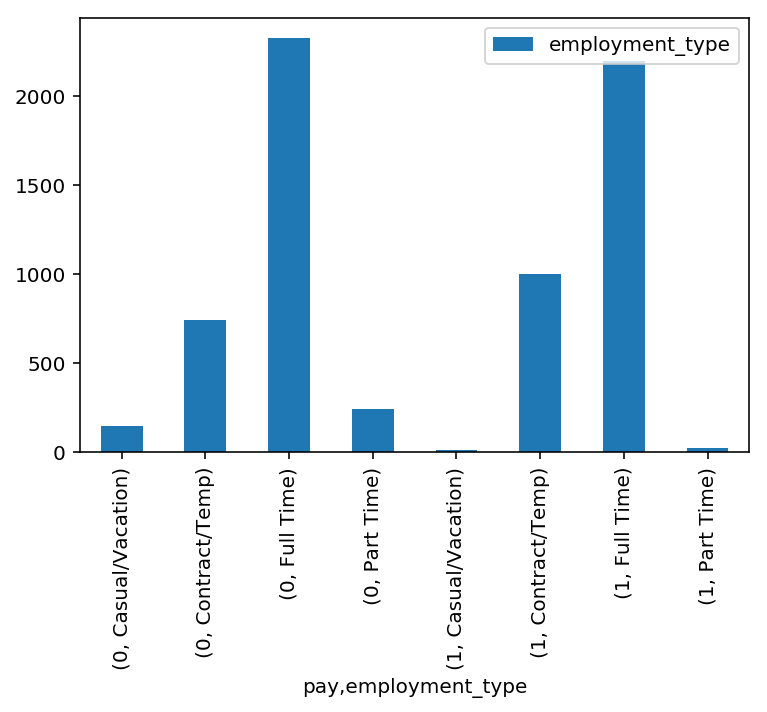

In [46]:
df.groupby(['pay','employment_type'])[['employment_type']].count().plot(kind = 'bar')

In [47]:
df.head()

,url,employment_type,field,pay,full_description,state
0,https://www.seek.com.au/job/37511263?type=stan...,Contract/Temp,Call Centre & Customer Service,0,Part Time Customer Service Officer We are curr...,SA
1,https://www.seek.com.au/job/37519438?type=stan...,Full Time,Engineering,1,ILS Lead Engineer & ILS Engineer (x4) ILS Lead...,SA
2,https://www.seek.com.au/job/37492206?type=stan...,Full Time,Accounting,0,Senior Finance Officer We are currently seekin...,NSW
3,https://www.seek.com.au/job/37452873?type=stan...,Full Time,Information & Communication Technology,1,Penetration Tester Role Highlights Join an Aus...,NSW
4,https://www.seek.com.au/job/37486647?type=stan...,Full Time,Engineering,1,Senior HVAC Drafter This position offers a mar...,NSW


### Basic EDA

In [48]:
from cLiML.eda import edaCategorical

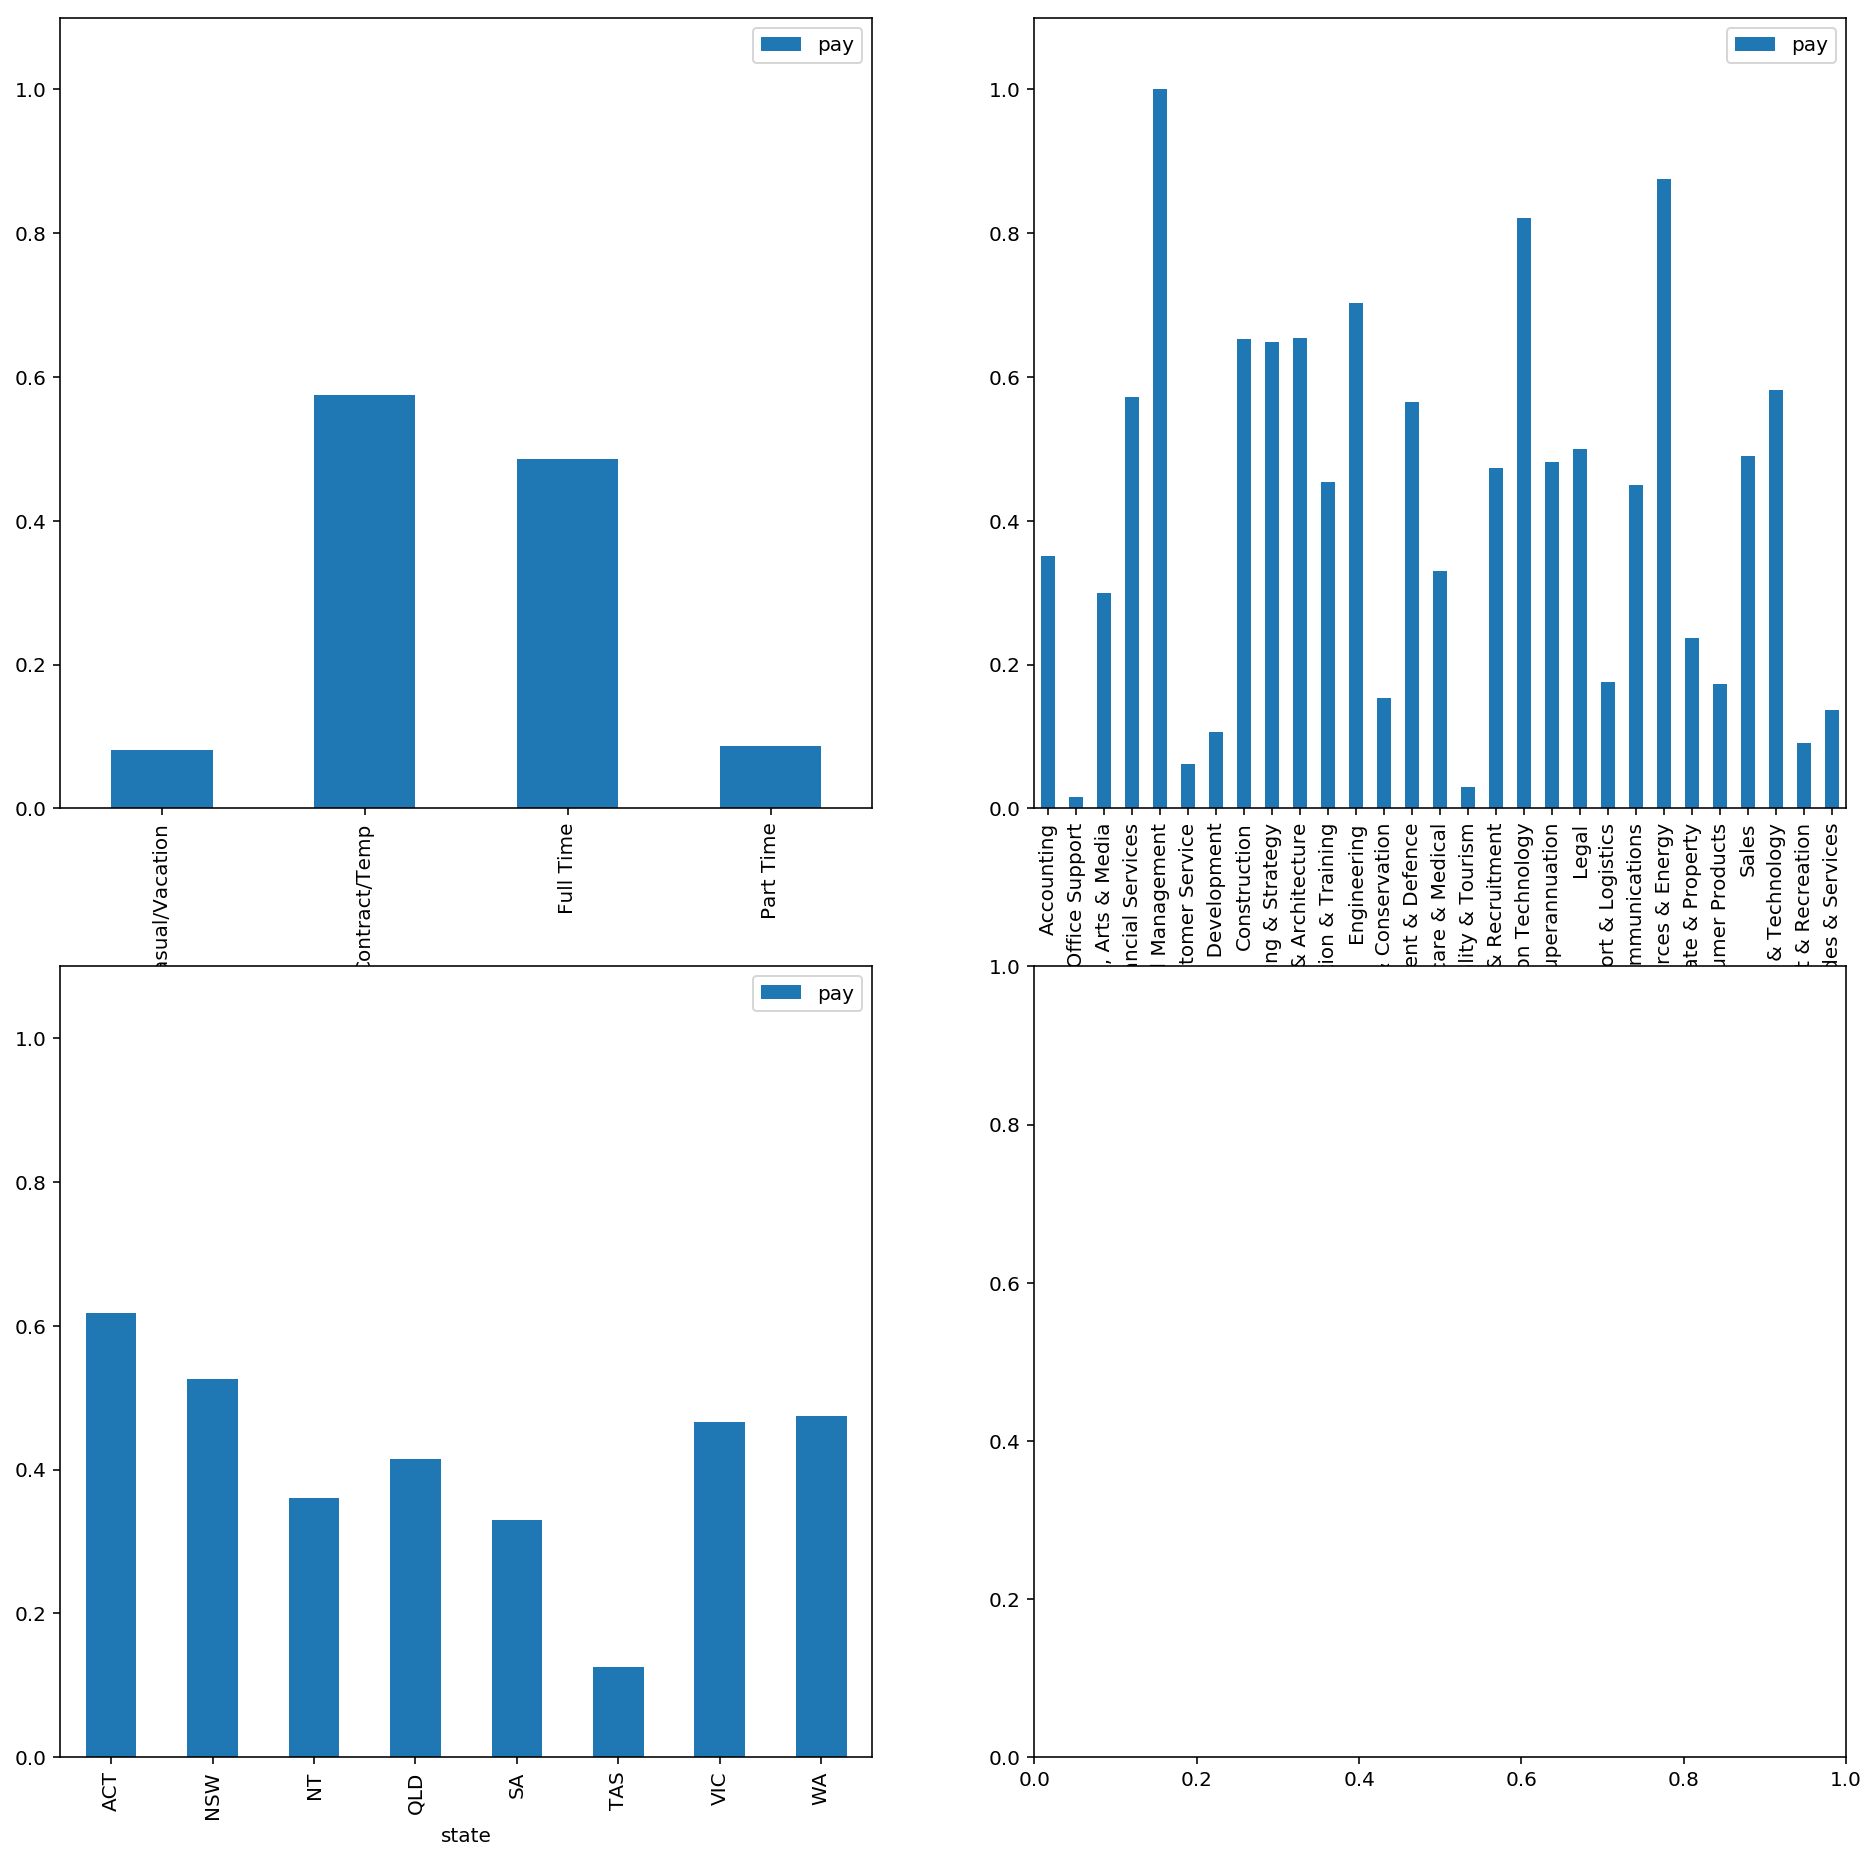

In [49]:
edaCategorical(df[['employment_type', 'field', 'state', 'pay']], target = 'pay',aggre = 'mean', max_y_axis = 1.1)

### Train Test Split

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
df.head()

,url,employment_type,field,pay,full_description,state
0,https://www.seek.com.au/job/37511263?type=stan...,Contract/Temp,Call Centre & Customer Service,0,Part Time Customer Service Officer We are curr...,SA
1,https://www.seek.com.au/job/37519438?type=stan...,Full Time,Engineering,1,ILS Lead Engineer & ILS Engineer (x4) ILS Lead...,SA
2,https://www.seek.com.au/job/37492206?type=stan...,Full Time,Accounting,0,Senior Finance Officer We are currently seekin...,NSW
3,https://www.seek.com.au/job/37452873?type=stan...,Full Time,Information & Communication Technology,1,Penetration Tester Role Highlights Join an Aus...,NSW
4,https://www.seek.com.au/job/37486647?type=stan...,Full Time,Engineering,1,Senior HVAC Drafter This position offers a mar...,NSW


In [52]:
X = df[['employment_type', 'field', 'full_description', 'state']]
y = df['pay']

In [53]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

### Dummifying the categorical variables

In [54]:
categorical_list = ['employment_type', 'field', 'state']

In [55]:
from cLiML.model_prep import dummify, dummify_test, match_test_to_train_columns

In [56]:
X_train = dummify(X_train, categorical_list)

In [57]:
X_test = dummify_test(X_test, categorical_list)

In [58]:
X_test = match_test_to_train_columns(X_test, X_train)

In [59]:
X_train.shape

(5359, 39)

In [60]:
X_test.shape

(1340, 39)

In [61]:
set(X_train.columns.values.tolist()) - set(X_test.columns.values.tolist())

set()

### Stemming the words

In [62]:
def stemSeries(value):
    #from nltk.stem.lancaster import LancasterStemmer
    from nltk.stem import PorterStemmer
    
    # clean up 
    value = value.replace('\xa0', ' ')
    value = value.replace(',', ' ')
    value = value.replace(';', ' ')
    value = value.replace('.', ' ')
    value = value.replace('\n', ' ')
    value = value.replace('\r', ' ')
    
    # lower case
    value = value.lower()
    
    # split into a list of words
    words = value.split(' ')
    
    # remove empty strings
    stemmed_list = []
    stemmer = PorterStemmer()
    for word in words:
        if word != '':
            try:
                stemmed_list.append(stemmer.stem(word))
            except:
                stemmed_list.append(word)

            
    # join into a stemmed description
    stemmed_des = ' '.join(stemmed_list)
    
    return stemmed_des

In [63]:
descriptions = []
for description in log_progress(X_train.full_description.values.tolist()):
    description = stemSeries(description)
    descriptions.append(description)

X_train['stemmed_description'] = descriptions

In [64]:
descriptions = []
for description in log_progress(X_test.full_description.values.tolist()):
    description = stemSeries(description)
    descriptions.append(description)

X_test['stemmed_description'] = descriptions

In [65]:
X_train = X_train.drop(columns = ['full_description'])

In [66]:
X_test = X_test.drop(columns = ['full_description'])

### Count Vectorising the description

In [67]:
X_train.head(1)

,employment_type_Casual/Vacation,employment_type_Contract/Temp,employment_type_Full Time,field_Accounting,field_Administration & Office Support,"field_Advertising, Arts & Media",field_Banking & Financial Services,field_CEO & General Management,field_Call Centre & Customer Service,field_Community Services & Development,...,field_Science & Technology,field_Sport & Recreation,state_ACT,state_NSW,state_NT,state_QLD,state_SA,state_TAS,state_VIC,stemmed_description
1381,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,sale support cooordin oji fibr solut part of a...


In [68]:
from sklearn.feature_extraction.text import CountVectorizer

In [69]:
vect = CountVectorizer(stop_words = 'english', ngram_range = (1,2))
X_train_vect = vect.fit_transform(X_train['stemmed_description'])
X_test_vect = vect.transform(X_test['stemmed_description'])

In [70]:
X_column_names = vect.get_feature_names()

In [71]:
X_train_sparse = X_train_vect.toarray()
X_test_sparse = X_test_vect.toarray()

In [72]:
X_train_sparse = pd.DataFrame(X_train_sparse, columns = X_column_names)

In [73]:
X_test_sparse = pd.DataFrame(X_test_sparse, columns = X_column_names)

In [74]:
X_train_sparse.shape

(5359, 335342)

In [75]:
X_train.shape

(5359, 39)

#### filter out the top most popular words

In [76]:
X_train_sparse_count = X_train_sparse.sum()

In [77]:
X_train_sparse_count = pd.DataFrame(X_train_sparse_count, columns = ['Count'])

In [78]:
X_train_sparse_count = X_train_sparse_count[X_train_sparse_count['Count'] > 500]

In [79]:
selected_columns = X_train_sparse_count.T.columns.values.tolist()

In [80]:
## Only grab the selected columns
X_train_sparse = X_train_sparse[selected_columns]
X_test_sparse = X_test_sparse[selected_columns]

#### Combine the sparse dataframe into the main dataframe

In [81]:
X_train.reset_index(drop = True, inplace = True)

In [82]:
X_test.reset_index(drop = True, inplace = True)

In [83]:
X_train = pd.concat([X_train, X_train_sparse], axis = 1)

In [84]:
X_test = pd.concat([X_test, X_test_sparse], axis = 1)

In [85]:
X_train.drop(columns = ['stemmed_description'], inplace = True)
X_test.drop(columns = ['stemmed_description'], inplace = True)

### Saving cleaned and processed data

In [86]:
X_train.to_csv('./readied_data/X_train.csv')
X_test.to_csv('./readied_data/X_test.csv')
y_train.to_csv('./readied_data/y_train.csv')
y_test.to_csv('./readied_data/y_test.csv')

In [87]:
X_train.shape

(5359, 728)

In [88]:
y_train.shape

(5359,)

In [89]:
y_train.head()

1381    0
2688    0
4785    0
3646    0
4867    0
Name: pay, dtype: int64